In [201]:
%matplotlib inline
import pandas as pd, ipywidgets as widgets, numpy as np, matplotlib.pyplot as plt, io
import string, math
from ipywidgets import interact, interactive, fixed, interact_manual

#Standard functions

#Function that ensures a given antibody platemap is formatted correctly (by columns, not rows)
#Mutable function that changes the data frame passed in by argument "ab_sheet"
#ie A1->B1-->H1->A2-->B2-->A12-->H12
#First, separate the Well ID into separate "Plate Number","Format Row" and "Format Column" values 
#(Row is Letter, Column is Number)
#Sort the platemap into proper Plate -> Column -> Row format
#Returns nothing, mutates the ab_sheet antibody plate map
def format_platemap(ab_sheet):
    ab_sheet["Format Row"] = ab_sheet["Well ID"].str.slice(start = 0, stop = 1)
    numeric_col = ab_sheet["Well ID"].str.slice(start = 1)
    numeric_col = pd.to_numeric(numeric_col)
    ab_sheet["Format Column"] = numeric_col
    ab_sheet.sort_values(by=["Plate Number","Format Column", "Format Row"], inplace=True, ignore_index = True)
    return

#Average function that takes a series with n=1, n=2 replicates in sequential order within the series, and 
#Separates n=1 and n=2 replicates resets indeces, and calculates average
#Returns a series with the averaged values, removing the replicate wells
def average(series_to_average):
    firsts = series_to_average.iloc[::2]
    seconds = series_to_average.iloc[1::2]
    firsts.reset_index(inplace = True, drop = True)
    seconds.reset_index(inplace = True, drop = True)
    averaged_series = firsts + seconds
    averaged_series = averaged_series/2
    return averaged_series

#Takes a Pandas dataframe as an input. Takes every column from the dataframe and concatenates them into one single series
#Returns the new series that has all of the data in one column, starting from 1st column -> max # of columns
def columnize(df_to_columnize):
    return_column = pd.Series()
    for column in df_to_columnize.columns:
        colToAdd = df_to_columnize[column]
        return_column = pd.concat([return_column, colToAdd], axis = 0, ignore_index = True)
    return return_column

In [171]:
#New functions written for M5 analysis

#Average function that returns an average series but also a series of the standard deviations for each average
def average_stddev(series_to_average):
    firsts = series_to_average.iloc[::2]
    seconds = series_to_average.iloc[1::2]
    firsts.reset_index(inplace = True, drop = True)
    seconds.reset_index(inplace = True, drop = True)
    averaged_series = firsts + seconds
    averaged_series = averaged_series/2
    stddev = (((firsts - averaged_series) ** 2) + ((seconds - averaged_series) ** 2) / 2) ** .5
    return averaged_series, stddev

#Parse data from the xlsx format from M5. Splits the raw data file into plates, not analysis ready, 
#and return a dictionary of {plate number : uncleaned data} key value pairs
#Accepts a Pandas dataframe that is the raw data from the M5, number of blocks in the raw data, 
#and the blocksize (default = 20)
def parse(data, numblocks, blocksize = 20):
    parsed_dict = {}
    for i in range(numblocks):
        rowstart = 0 + blocksize * i
        rowend = 18 + blocksize * i
        df = data.iloc[rowstart:rowend, 0:26]
        df.reset_index(inplace = True, drop = True)
        parsed_dict[i+1] = df
    return parsed_dict
        
#For each plate parsed, clean unnecessary data and return a dictionary of {plate name: cleaned data} key value pairs
#Accepts a dictionary of raw plates. Cleans each plate and renames axes to proper 384 well format
#Returns a dictionary of cleaned plates
def clean(parsedplates):    
    cleaned_dict = {}
    for key, plate in parsedplates.items():
        platename = plate[1][0]
        data = plate.iloc[2:, 2:27]
        data.reset_index(inplace = True, drop = True)
        cleaned = pd.DataFrame(data)
        #rename_axes(cleaned)
        cleaned.index += 1
        cleaned.rename(columns = dict(zip(list(cleaned.columns), list(range(1, 25)))), inplace = True)
        cleaned_dict[platename] = cleaned
    return cleaned_dict

#Function to divide one plate by another. Check keys. Plate name should be organized in 
#"*Target* *Assay*"" format, with assay being the last substring after a space. 
# platedic - a dictionary of {Plate Name: Data} key/value pairs to perform the division on
# assaynum - a string of the name of the assay that should be the numerator (FFLuc in NanoLuc, Venus in BRET)
# assyden - a string of the name of assay that should be the denominator (RLuc in NanoLuc)
# Returns a new dictionary with the {receptorname_assaynum/assayden : divided data} key value pairs.
def divplate(platedic, assaynum, assayden):
    divdict = {}
    plates = platedic.keys()
    for key in plates:
        receptor = key[:len(key) - len(assaynum)]
        receptorden = receptor + assayden
        if assaynum in key and receptorden in plates:
            divdict[f"{key}-{assayden}"] = platedic[key] / platedic[receptorden] 
    return divdict

#Averages n=1 and n=2 duplicates in a 384 well plate
#Accepts a dictionary of cleaned plates, and returns a dictionary of {plate name: averaged}
#and a dictionary of {plate name: standard deviation}
def average_plates(platestoaverage):
    averagedplates = {}
    stddev = {}
    for key, plate in platestoaverage.items():
        valuedf = pd.DataFrame()
        devdf = pd.DataFrame()
        for col in plate.columns:
            valuecol, devcol = average_stddev(plate[col])
            valuedf[col] = valuecol
            devdf[col] = devcol
        rename_averaged_axes(valuedf)
        rename_averaged_axes(devdf)
        averagedplates[key] = valuedf
        stddev[key] = devdf
    return averagedplates, stddev

#Accepts a dictionary of plates, and preps each plate for reshaping via .pivot
#Adds an "n" column, and collapses indeces to 8 (to account for duplicates)
def prep_pivot(platedict):
    for plate in platedict.values():
        plate["n"] = pd.Series([2,1]*len(plate/2))
        plate.rename_axis("Column", axis = "columns", inplace = True)
        plate.rename_axis("Row", axis = "index", inplace = True)
        plate.index = plate.index.map(collapse_dups)

#Mapper function to pass into Series.map()
#Used to collapse the indeces from 1->16 to 1->8 to account for duplicate rows in 384 well format
def collapse_dups(index):
    if index % 2 == 0:
        return index / 2
    return index // 2 + 1
        
#Takes the dataframe parsed from raw format off of M5 and changes Columns to be 1->24, and changes rows to be A->P
#Mutative function, doesn't return a new dataframe, but changes the existing dataframe that is passed in
def rename_axes(df):
    rownames = dict(zip(list(range(0, 16)), list(string.ascii_lowercase)[0:17]))
    colnames = dict(zip(list(range(2, 26)), list(range(1, 25))))
    df.rename(index = rownames, inplace=True)
    df.rename(columns = colnames, inplace = True)

#Changes rows from A->H
def rename_averaged_axes(df):
    rownames = dict(zip(list(range(0, 8)), list(string.ascii_lowercase)[0:8]))
    df.rename(index = rownames, inplace=True)

In [2]:
eln_uploader = widgets.FileUpload(multiple = False)
display("Upload ELN w/ Functional Data and Antibodies Sheet (xlsx), and specify assay type")
display(eln_uploader)

'Upload ELN w/ Functional Data and Antibodies Sheet (xlsx), and specify assay type'

FileUpload(value={}, description='Upload')

In [173]:
elnname = list(eln_uploader.value.keys())[0]
rawdata = pd.read_excel(io.BytesIO(eln_uploader.value[elnname]['content']))
headers = [i for i in range(len(rawdata.columns))]
headers[0] = rawdata.columns[0]
rawdata = pd.read_excel(io.BytesIO(eln_uploader.value[elnname]['content']), names = headers)
rawdata

,##BLOCKS= 4,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,Plate:,SRE SC124 FFLuc,1.300,PlateFormat,Endpoint,Luminescence,Raw,0.000,1.000,NaN,...,NaN,NaN,NaN,NaN,1.000,NaN,NaN,NaN,1.0,16.0
1,NaN,Temperature(¡C),1.000,2,3,4,5,6.000,7.000,8.000,...,19.000,20.000,21.000,22.000,23.000,24.000,NaN,NaN,NaN,NaN
2,NaN,24.2,16586.641,18221.801,16228.95,13398.082,12529.404,11609.627,15748.623,14614.231,...,70506.008,78937.289,71364.461,74655.219,75278.625,69903.039,NaN,NaN,NaN,NaN
3,NaN,NaN,15350.053,15687.305,12927.974,15595.326,9780.293,14338.298,17424.660,14859.505,...,67041.508,81379.805,67388.984,62422.184,65018.000,63495.258,NaN,NaN,NaN,NaN
4,NaN,NaN,12468.085,16044.995,14583.572,16964.771,10035.787,15963.237,14471.155,15237.635,...,71803.906,73592.359,62544.820,69913.258,70894.352,64639.871,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,NaN,NaN,49627.039,50651.336,46123.953,38656.852,46441.484,53877.863,44730.918,57893.094,...,42026.777,48397.887,36167.820,28383.186,23282.199,13254.363,NaN,NaN,NaN,NaN
77,NaN,NaN,40500.582,42948.641,35184.496,34672.348,43809.055,56325.926,50221.129,52679.437,...,38564.668,40623.500,35440.570,23784.105,14811.290,19512.801,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,~End,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
numblocks = int(rawdata.columns[0][10:])

parsedplates = parse(rawdata, numblocks)
cleanplates = clean(parsedplates)
finalplates = divplate(cleanplates, "FFLuc", "RLuc")
finalplates
# prep_pivot(finalplates)
# finalplates
# averagedplates, stddevplates = average_plates(dividedplates)
# averagedplates

{'SRE SC124 FFLuc-RLuc':           1          2         3         4         5         6         7   \
 1   1.119188   1.004212  0.903527  0.780029  0.723015  0.664852  0.946090   
 2   0.792910   0.770931  0.659115  0.729132  0.585394  0.802368  0.946974   
 3   0.743999   0.846195   0.70817  0.895184  0.680916  0.836931  0.651113   
 4   0.838974   0.650742  0.613203  0.691487  0.649987  0.578359  0.831363   
 5   0.724404   0.877656  0.655478  0.609561  0.620532  0.557759  0.594441   
 6   1.094786    0.84627  0.783825   0.83453  0.661557  0.877088  0.705383   
 7   0.941389   1.306668  0.775727  0.661557   0.51149  0.663993  0.786750   
 8   1.043065   1.413539  0.781828  0.834402  0.599725  0.770480  0.764565   
 9   0.863090   2.300622  0.760027  0.647239  0.737635  0.988608  0.825301   
 10  1.150419   1.930191  0.850069  0.855408  0.755537  0.800300  0.850336   
 11  1.190497   4.934754  0.710055  0.675891  0.629098  1.199334  0.855817   
 12  1.187026   5.380265  0.853197  0.67

In [189]:
ptdict = {}
for key, plate in finalplates.items():
    ptdict[key] = plate.pivot(columns = "n")
ptdict

{'SRE SC124 FFLuc-RLuc': Column        1                   2                    3                   4   \
 n              1         2         1          2         1         2         1   
 Row                                                                             
 1.0     1.119188  0.792910  1.004212   0.770931  0.903527  0.659115  0.780029   
 2.0     0.743999  0.838974  0.846195   0.650742   0.70817  0.613203  0.895184   
 3.0     0.724404  1.094786  0.877656    0.84627  0.655478  0.783825  0.609561   
 4.0     0.941389  1.043065  1.306668   1.413539  0.775727  0.781828  0.661557   
 5.0     0.863090  1.150419  2.300622   1.930191  0.760027  0.850069  0.647239   
 6.0     1.190497  1.187026  4.934754   5.380265  0.710055  0.853197  0.675891   
 7.0     1.091565  1.319625  7.752143   9.019414  0.808771  0.953053  0.643869   
 8.0     1.258364  1.390183  9.724052  11.931459  0.837691  0.953758  0.732016   
 
 Column                  5             ...        20                  21

In [193]:
writer = pd.ExcelWriter("FFLuc-RLuc.xlsx", engine = "openpyxl")
for name, plate in ptdict.items():)
    plate.to_excel(writer, sheet_name = name)
writer.save()

SRE SC124 FFLuc-RLuc
Column        1                   2                    3                   4   \
n              1         2         1          2         1         2         1   
Row                                                                             
1.0     1.119188  0.792910  1.004212   0.770931  0.903527  0.659115  0.780029   
2.0     0.743999  0.838974  0.846195   0.650742   0.70817  0.613203  0.895184   
3.0     0.724404  1.094786  0.877656    0.84627  0.655478  0.783825  0.609561   
4.0     0.941389  1.043065  1.306668   1.413539  0.775727  0.781828  0.661557   
5.0     0.863090  1.150419  2.300622   1.930191  0.760027  0.850069  0.647239   
6.0     1.190497  1.187026  4.934754   5.380265  0.710055  0.853197  0.675891   
7.0     1.091565  1.319625  7.752143   9.019414  0.808771  0.953053  0.643869   
8.0     1.258364  1.390183  9.724052  11.931459  0.837691  0.953758  0.732016   

Column                  5             ...        20                  21  \
n           

KeyError: 'Concentration'

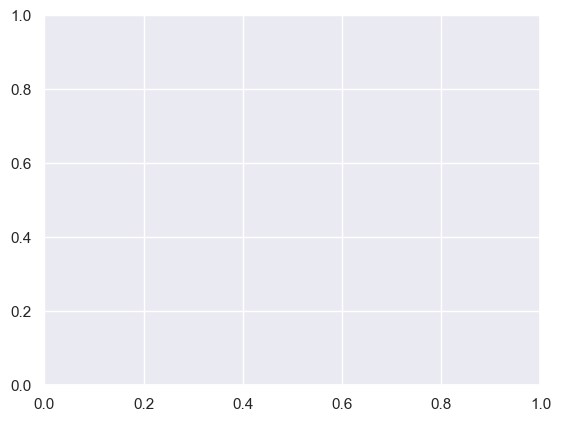

In [241]:
# import seaborn as sns

concentration = dict(zip(list(range(1, 9)), list(range(-12, -4))))
# sns.set_theme()
# ptdict['CD117 SRF FFLuc-RLuc'][1].plot(xticks = concentration)
tt = ptdict['CD117 SRF FFLuc-RLuc'].loc[:, 1].rename(index = concentration).rename_axis(index = "Concentration")
tt.plot(kind='scatter', x = "Concentration", y = 'n')